### IMPORT LIBRARIES AND TWITTER API SET UP

In [1]:
import tweepy
from tweepy import Stream, OAuthHandler, StreamListener
import json
import time
from collections import Counter
import re
import pandas as pd
import numpy as np
from langdetect import detect
import pyprind
import deepdish as dd

In [2]:
#import secret codes
from twitter_pwd import access_token, access_token_secret, consumer_key, consumer_secret

In [3]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

### KEY FUNCTIONS : USERS, FOLLOWERS, TIMELINES, LANGS

In [4]:
def get_account_network(account_name, rel_type='followers', max_num =100, key_words=None, 
                        min_num_tweets=0, min_num_followers=0):
    """ Given an account by account_name, 
        find all users that are linked to it via a specified relation type 'rel_type'.
        Args:
            * account_name: string. Twitter account name
            * rel_type: string. Specifies relation type (default is 'followers')
            * max_num: integer. Maximum number of 'related' users considered
            * key_words: list of strings. Used to filter retrieved users by location,
                if specified
            * min_num_tweets: minimum number of tweets a follower needs to have 
                to be included in list
            * min_num_followers: minimum number of followers a follower needs to have 
                to be included in list
        Returns:
            * list_people: list of account_names
    """
    pbar = pyprind.ProgBar(max_num)
    list_people = []
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    # limit max number of followers requested to max exisitng followers
#     num_acc_followers = api.get_user(account_name)
#     if  num_acc_followers <= max_num:
#         max_num = num_acc_followers
        
    # very important to set count=200 MAX VALUE -> Max 3000 accounts per 15 minutes interval
    users = tweepy.Cursor(getattr(api, rel_type, 0), 
                          screen_name=account_name, count=200).items(max_num)
    while True:
        try:
            user = next(users)
            if not key_words:
                if user.statuses_count > min_num_tweets:
                    list_people.append(user._json)
            else:
                locs = '|'.join(key_words)
                patt = re.compile(locs)
                found_loc = re.findall(patt, user._json['location'])
                if found_loc and user.statuses_count > min_num_tweets:
                    list_people.append(user._json)
        except tweepy.TweepError as e:
            if 'Read timed out' in str(e):
                print('fallen here')
                print(e)
                time.sleep(5)
            else:
                time.sleep(60*16)
                user = next(users)
        except StopIteration:
            break            
        pbar.update()
    return list_people
        

In [5]:
def get_account_tweets(account_name, max_num_twts=20):
    """ Given an account name,
        it retrieves a maximum number of tweets written or retweeted by account owner.
        It returns them in a list.
        Args:
            * account name: string. Screen_name that identifies the twitter account
            * max_num_twts: integer. Maximum number of tweets to be retrieved for each account
        Returns:
            * list_tweets: list including info of all retrieved tweets in JSON format"""
    list_tweets=[]
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    timeline = tweepy.Cursor(api.user_timeline, screen_name=account_name, 
                             count=200, include_rts = True).items(max_num_twts)
    i=0
    while True:
        try:
            tw = next(timeline)
            list_tweets.append(tw)
        except tweepy.TweepError as e:
            if '401' in str(e):    
                print(e)
                time.sleep(10)
                break
            else:
                time.sleep(60*15)
                tw = next(timeline)
        except StopIteration:
            break
    return list_tweets

In [6]:
def get_tweets_from_accounts(list_accounts, max_num_accounts=None, max_num_twts=20):
    """ Given a list of accounts, get tweets texts, langs and authors
        All URLs and tweet account names are removed from tweet
        texts since they are not relevant for language identification"""
    pbar = pyprind.ProgBar(len(list_accounts))
    texts_tweets = []
    langs_tweets = []
    authors_tweets = []
    if max_num_accounts:
        list_accounts = list_accounts[:max_num_accounts]
    for idx, acc in enumerate(list_accounts):
        twts = get_account_tweets(acc, max_num_twts=max_num_twts)
        texts_tweets.extend([re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", tw.text) 
                             for tw in twts])
        langs_tweets.extend([tw.lang for tw in twts])
        authors_tweets.extend([acc for _ in twts])
        #[detect(txt) for txt in texts_tweets if re.sub(" ","", txt)])
        pbar.update()
    return texts_tweets, langs_tweets, authors_tweets

In [7]:
def save_tweets_from_followers(screen_name, country, node_name, city=None, 
                               min_num_twts_per_acc=5, max_num_followers=None):
    """ Creates pandas dataframe with all tweets texts 
        from followers of a given account and corresponding language. 
        A dataframe with all followers info must have been previously computed 
        and saved in hdf5 format
        Args:
            * screen_name:
            * country:
            * node_name:
    """
    base_path = '/'.join(['',country, node_name, screen_name])
    path_load = base_path + '/followers'
    path_save = base_path + '/tls_followers'
    key_words = {'ukr':{'all':r"(Україна|Ukraine|Украина|Київ|Киев|Kiev|Kyiv|Львів|Львов|Одес)", 
                        'Kiev':r"(Kiev|Kyiv|Київ|Киев)"}, 
                 'cat':{'all':r"(Barcel|Catal|Tarr|Llei|Ger|Gir|Badal|Sabad|Terrass)",
                        'Terrassa':r"(Terras|Vall)",
                        'Girona':r"(Giro|Gero)",
                        'Vic':r"(Vic|Oson)", 'Barcelona':r"(Barcel|barcel|Bcn|bcn)",
                        'Tarragona':r"(Tarrag|tarrag)", 'Lleida':r"(Lleida|Lerid|Lérid)",
                        'Badalona':r"Badal"}}
    df = pd.read_hdf('lang_data.h5', path_load)
    # filter by num_min_twts_per_account
    relevant_followers = df['screen_name'][df['statuses_count'] >= min_num_twts_per_acc]
    # keep only country residents
    if city:
        relevant_followers = relevant_followers[df['location'].str.contains(key_words[country][city])].values
    else:
        relevant_followers = relevant_followers[df['location'].str.contains(key_words[country]['all'])].values
        
    texts, langs, auth = get_tweets_from_accounts(relevant_followers, 
                                                  max_num_accounts=max_num_followers)
    df_txts_langs= pd.DataFrame({'texts':texts, 'lang':langs, 'screen_name':auth})
    df_txts_langs.to_hdf('lang_data.h5', path_save)
    return df_txts_langs
    
    

In [8]:
import tweepy

class CityTweets:
    key_words = {'ukr':{'all':r"(Україна|Ukraine|Украина|Київ|Киев|Kiev|Kyiv|Львів|Львов|Одес)", 
                    'Kiev':r"(Kiev|Kyiv|Київ|Киев)"}, 
                 'cat':{'all':r"(Barcel|Catal|Tarr|Llei|Ger|Gir|Badal)",
                        'Terrassa':r"(Terras|Vall)",
                        'Girona':r"(Giro|Gero)",
                        'Vic':r"(Vic|Oson)", 'Barcelona':r"(Barcel|barcel|Bcn|bcn)",
                        'Tarragona':r"(Tarrag|tarrag)", 'Lleida':r"(Lleida|Lerid|Lérid)",
                        'Badalona':r"Badal"}}
    def __init__(self, account_name, min_num_tweets=0, 
                 min_num_followers=0, key_words=None):
        self.account_name = account_name
        self.min_num_tweets = min_num_tweets
        self.min_num_followers = min_num_followers
        self.key_words = key_words
        
        self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        
    def get_account_network(rel_type='followers', max_num =100, key_words=None, 
                            min_num_tweets=0, min_num_followers=0):
        """ Given an account by account_name, 
            find all users that are linked to it via a specified relation type 'rel_type'.
            Args:
                * rel_type: string. Specifies relation type (default is 'followers')
                * max_num: integer. Maximum number of 'related' users considered
                * key_words: list of strings. Used to filter retrieved users by location,
                    if specified
                * min_num_tweets: minimum number of tweets a follower needs to have 
                    to be included in list
                * min_num_followers: minimum number of followers a follower needs to have 
                    to be included in list
            Returns:
                * list_people: list of account_names
        """
        pbar = pyprind.ProgBar(max_num)
        self.list_people = []
        
        # very important to set count=200 MAX VALUE
        users = tweepy.Cursor(getattr(self.api, rel_type, 0), screen_name=self.account_name, 
                              count=200).items(max_num)
        while True:
            try:
                user = next(users)
                if not key_words:
                    if user.statuses_count > min_num_tweets and user.followers_count > min_num_followers:
                        self.list_people.append(user._json)
                else:
                    locs = '|'.join(key_words)
                    patt = re.compile(locs)
                    found_loc = re.findall(patt, user._json['location'], flags=re.I)
                    if found_loc and user.statuses_count > min_num_tweets and user.followers_count > min_num_followers:
                        self.list_people.append(user._json)
            except tweepy.TweepError as e:
                if 'Read timed out' in str(e):
                    print('fallen here')
                    print(e)
                    time.sleep(5)
                else:
                    time.sleep(60*16)
                    user = next(users)
            except StopIteration:
                break            
            pbar.update()
    
    def get_account_tweets(max_num_twts=20):
        """ Given an account name,
            it retrieves a maximum number of tweets written or retweeted by account owner.
            It returns them in a list.
            Args:
                * account name: string. Screen_name that identifies the twitter account
                * max_num_twts: integer. Maximum number of tweets to be retrieved for each account
            Returns:
                * list_tweets: list including info of all retrieved tweets in JSON format
        """
        list_tweets=[]
        timeline = tweepy.Cursor(self.api.user_timeline, screen_name=self.account_name, 
                                 count=200, include_rts = True).items(max_num_twts)
        i=0
        while True:
            try:
                tw = next(timeline)
                list_tweets.append(tw)
            except tweepy.TweepError as e:
                if '401' in str(e):    
                    print(e)
                    time.sleep(10)
                    break
                else:
                    time.sleep(60*15)
                    tw = next(timeline)
            except StopIteration:
                break
        return list_tweets
    
    def get_tweets_from_accounts(max_num_accounts=None, max_num_twts=20):
        """ Given a list of accounts, get tweets texts, langs and authors
            All URLs and tweet account names are removed from tweet
            texts since they are not relevant for language identification
        """
        pbar = pyprind.ProgBar(len(list_accounts))
        texts_tweets = []
        langs_tweets = []
        authors_tweets = []
        if max_num_accounts:
            list_accounts = self.list_people[:max_num_accounts]
        for idx, acc in enumerate(list_accounts):
            twts = self.get_account_tweets(acc, max_num_twts=max_num_twts)
            texts_tweets.extend([re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", tw.text) 
                                 for tw in twts])
            langs_tweets.extend([tw.lang for tw in twts])
            authors_tweets.extend([acc for _ in twts])
            pbar.update()
        return texts_tweets, langs_tweets, authors_tweets

    
    def save_tweets_from_followers(screen_name, country, node_name, city=None, 
                                   min_num_twts_per_acc=10, max_num_followers=None):
        """ Creates pandas dataframe with all tweets texts 
            from followers of a given account and corresponding language. 
            A dataframe with all followers info must have been previously computed 
            and saved in hdf5 format
            Args:
                * screen_name:
                * country:
                * node_name:
        """
        base_path = '/'.join(['',country, node_name, screen_name])
        path_load = base_path + '/followers'
        path_save = base_path + '/tls_followers'

        df = pd.read_hdf('lang_data.h5', path_load)
        # filter by num_min_twts_per_account
        relevant_followers = df['screen_name'][df['statuses_count'] >= min_num_twts_per_acc]
        # keep only country residents
        if city:
            relevant_followers = relevant_followers[df['location'].str.contains(self.key_words[country][city])].values
        else:
            relevant_followers = relevant_followers[df['location'].str.contains(self.key_words[country]['all'])].values

        texts, langs, auth = self.get_tweets_from_accounts(max_num_accounts=max_num_followers)
        df_txts_langs= pd.DataFrame({'texts':texts, 'lang':langs, 'screen_name':auth})
        df_txts_langs.to_hdf('lang_data.h5', path_save)
        return df_txts_langs




In [9]:
mytxt = "киев"
re.findall(r"Київ|Киев", mytxt, flags=re.I )

['киев']

### UKRAINE: data structure and relevant twitter accounts 

In [12]:
Ukraine_nodes = {}
Ukraine_nodes['cities'] = ['kiev', 'odessa', 'lviv', 'kharkov', 'dnipropetrovsk']
Ukraine_nodes['city_sites'] = {'Mariupol':['0629ComUa'], 
                               'kiev':['nashkiev', 'kievtypical', 
                                       'kliniki_kiev', 'LISOD_clinic','avto_kiev', 
                                       'editbeauty']}
Ukraine_nodes['news'] = ['HromadskeUA', 'tsnua', 'ukrpravda_news', 'lb_ua', 'Korrespondent', 
                         'Delo_ua', 'BBC_ua', 'LIGAnet', 'segodnya_life']
Ukraine_nodes['TV'] = ['5channel', 'EspresoTV', '24tvua', 'footballua_tv']
Ukraine_nodes['starsystem'] = ['VeraBrezhneva', 's_vakarchuk', 'KAMEHCKUX']
Ukraine_nodes['politics'] = ['poroshenko', 'Vitaliy_Klychko', 
                             'Leshchenkos', 'AvakovArsen', 'andriy_sadovyi', 'GennadyKernes']

In [14]:
key_words=['Україна', 'Ukraine', 'Украина', 'Київ', 'Киев']
HromadskeUA_followers = get_account_network('HromadskeUA', rel_type='followers', 
                                            max_num =5000, key_words=key_words)

In [130]:
country = 'ukr'
node_name = 'politics'
acc_name = 'poroshenko'
rel_type = 'followers'

#key_words=['Україна', 'Ukraine', 'Украина', 'Київ', 'Киев']
path_save = '/'.join(['',country, node_name, acc_name, rel_type])
followers = get_account_network(acc_name, rel_type=rel_type, 
                                max_num =5000, key_words=None)
json_format = [elem._json for elem in followers]
df = pd.DataFrame(json_format)
df.to_hdf('lang_data.h5', path_save)

In [8]:
df[['location','screen_name','lang']][df['location'].str.contains(r"(Львів|Львов)")]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,location,screen_name,lang
522,Україна Львів,juliaskab13,uk
1006,Львов,novinska_cat,ru
1661,Львов,HumenuykRoma,ru
2269,Львів,kaprikorn87,uk
2997,Україна Львів,Hollywell83,uk
3803,м .Львів,M8tgs4YGZ391fNw,uk
4731,Львів,cherniak_gi,uk


In [9]:
df['lang'][df['location'].str.contains(r"(Львів|Львов|Lviv|Івано-Франківськ)")].value_counts()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


uk    8
ru    3
en    1
Name: lang, dtype: int64

In [10]:
df['lang'][df['statuses_count'] >= 10][df['location'].str.contains(r"(Kiev|Kyiv|Київ|Киев)")].value_counts()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


ru    14
en     2
uk     1
Name: lang, dtype: int64

In [278]:
df[['lang','screen_name', 'followers_count']][df['statuses_count'] >= 200][df['location'].str.contains(r"(Kiev|Kyiv|Київ|Киев)")]

In [78]:
#HRMUA_flwrs = [f for idx, f in df_HRMUA.iterrows()]
#HRMUA_texts, HRMUA_langs = get_tweets_from_accounts(HRMUA_flwrs, max_num_followers=300)

In [66]:
df_txts_langs_HRMUA = pd.DataFrame({'texts':HRMUA_texts, 'lang':HRMUA_langs})

df_txts_langs_HRMUA.to_hdf('lang_data.h5', '/ukr_nodes/news/HromadskeUA/tls_followers')

In [ ]:
df_txts = pd.read_hdf('lang_data.h5', '/ukr_nodes/news/HromadskeUA/tls_followers')

### CATALONIA NODES

In [392]:
Catalonia_nodes = {}
Catalonia_nodes['news'] = ['LaVanguardia', 'VilaWeb', 'diariARA', 'elperiodico',
                           'elperiodico_cat', 'elpuntavui']
Catalonia_nodes['cities'] = ['bcn_ajuntament', 'paerialleida', 'girona_cat', 'TGNAjuntament', 
                             'AjBadalona', 'aj_vic', 'ajterrassa']
Catalonia_nodes['politics'] = ['KRLS', 'junqueras', 'AdaColau', 
                              'miqueliceta', 'InesArrimadas', 'Albiol_XG', 
                              'raulromeva', 'ForcadellCarme']

In [87]:
def get_account_followers(country, node, acc_name):
    path_save = '/'.join(['', country, node, acc_name, 'followers'])
    followers = get_account_network(acc_name, rel_type='followers', max_num =5000)
    json_format = [elem._json for elem in followers]
    df = pd.DataFrame(json_format)
    df.to_hdf('lang_data.h5', path_save)
    return df
    

In [129]:
# df = get_account_followers(country ='cat', node='cities', acc_name='AjBadalona')

In [89]:
df['lang'].value_counts()

es       3586
ca       1102
en        271
fr          9
it          7
en-gb       5
pt          4
de          3
eu          2
ar          2
ru          2
gl          1
pl          1
en-GB       1
zh-cn       1
ja          1
tr          1
ro          1
Name: lang, dtype: int64

In [90]:
regex = r"(Badal)"
df_Bad = df[df['statuses_count'] >= 10][df['location'].str.contains(regex)]
df_Bad['lang'].value_counts()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


es    688
ca    281
en     51
fr      1
it      1
Name: lang, dtype: int64

### SAVE TWEETS FROM FOLLOWERS

In [127]:
df_txts_langs = save_tweets_from_followers('AjBadalona' , 'cat', 'cities', city='Badalona')

In [128]:
# df_txts_langs['lang'].value_counts()

### LANG DETECTION

In [12]:
from langdetect import detect_langs

In [5]:
import langdetect

In [171]:
df_txts_langs.keys()

Index(['lang', 'screen_name', 'texts'], dtype='object')

In [44]:
df_txts_langs[['texts', 'lang', 'screen_name']][df_txts_langs['lang'] == 'und'].iloc[2]

NameError: name 'df_txts_langs' is not defined

In [272]:
base_path = '/'.join(['',country, node_name, screen_name])
path_load = base_path + '/followers'
path_save = base_path + '/tls_followers'

In [280]:
df = pd.read_hdf('lang_data.h5', path_save)

In [230]:
# filter followers to focus on most relevant ones
min_num_twts = 5
relevant_followers = df['screen_name'][df['statuses_count'] >= min_num_twts][
                         df['location'].str.contains(key_words[country])
                       ].values

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [122]:
#df_txts_langs['lang'].value_counts()
#langs_detected = [detect(txt) for txt in df_txts_langs['texts']]

langs_detected=[]
for txt in df_txts_langs['texts']:
    try:
        langs_detected.append(detect(txt))
    except:
        langs_detected.append(None)

In [55]:
df_try = pd.DataFrame({'a':['aaaa','bbbfdde',1],'b':[23,44,56]})
df_try2 = pd.DataFrame({'a':['xxxx','zzzz'],'b':[3233,43214]})

store = pd.HDFStore('try_hyerar.h5')

store.append('city/topic', df_try)

store.close()

pd.read_hdf('try_hyerar.h5', 'city/topic')

store = pd.HDFStore('try_hyerar.h5','a')

store.append('city/topic', df_try2)

store.close()

pd.read_hdf('try_hyerar.h5', 'city/topic')

store = pd.HDFStore('try_hyerar.h5','a')

store.put('city/followers',df)

store.close()

### EXPLORE AN ACCOUNT

In [851]:
api = tweepy.API(auth)
user_info = api.get_user('kliniki_kiev')  #ArnauAndreu
user_info._json['location']

'Украина, Киев'

In [852]:
user_info.followers_count

2287

In [20]:
#get timeline
tl = get_account_tweets('onlyforulonely',max_num_twts=200)

In [222]:
my_str = "@dijdoer frefe tt http://ewdowide.ewd.ewde ewdwed @jeiwo @ pgvila http://ewdowide.ewd.ewde oo"
re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", my_str)

' frefe tt  ewdwed    oo'

In [394]:
#[(elem._json['lang'],elem._json['text']) for elem in tl]

In [24]:
detect("Ну нічого-нічого, скоро і моя інста стане популярною і всі будуть такі мол огоо Ладка яка ти класна, а я така оо дякую цьом-цьом.")

'uk'

In [393]:
#user_info._json

In [324]:
my_friends = get_account_network('ArnauAndreu')

my_df = pd.DataFrame(my_followers)

Counter([friend.lang for friend in my_friends])

my_fr_txts, my_friends_lang = get_tweets_from_accounts(my_friends)

#Counter(my_friends_lang)



# my_fr_langs_detected=[]
# for i,txt in enumerate(my_fr_txts):
#     #print(i, txt)
#     try:
#         my_fr_langs_detected.append(detect(txt))
#     except:
#         continue

#Counter(my_fr_langs_detected)

usr_tl = get_account_tweets(my_friends[44].screen_name, max_num=10)

df_try=pd.DataFrame([twt._json for twt in usr_tl])
df_try.columns

my_tl = get_account_tweets('ArnauAndreu', max_num=10)

### MERGE DFs

In [397]:
#get hdf database keys
with pd.HDFStore('lang_data.h5') as f:
    my_keys = f.keys()

In [45]:
file_path = 'lang_data.h5'
country = 'cat'
acc_names = ['diariARA', 'LaVanguardia']
load_node1 = '/' + country + '_nodes/news/' + acc_names[0] + '/tls_followers'
load_node2 = '/' + country + '_nodes/news/' + acc_names[1] + '/tls_followers'

df1 = pd.read_hdf(file_path, load_node1)
df2 = pd.read_hdf(file_path, load_node2)

In [46]:
df_merged = pd.merge(df1, df2, how='outer')

In [47]:
df_merged.shape, df1.shape, df2.shape

((44937, 2), (34461, 2), (12181, 2))

### TWITTER RANDOM WALK

#### Establish city's lingua franca out of random inhabitants that are also Twitter users

1. Make a set with 5-10 relevant inhabitants or accounts, with lots of followers and tweets. Start from mayor, city hall account, local newspapers, police, traffic or any other relevant account based in the city.

2. Get a follower from the city (or county, oblast) as first node ( Check this follower 
   has sufficient tweets and followers)

3. Get follower of step2 node

4. Repeat step3 with new nodes until max number of nodes is reached

Criteria to keep tweets from user:
1. User ratio num_tweets/num_followers < 30
2. User ratio num_friends/num_followers < 10

###### UPDATE ALGO

1. Update all acc networks(s1) with 'get_main_unique_followers' and s2 = saved_ones (get them from unique saved tweet authors) main_unique_followers 

2. Check s1.difference(s2)

3. new_twts = RWCT.get_account_tweets(new_unique_follws)

4. old_twts = RWCT.load_main_unique_followers() and old_twts.append(new_twts)

In [115]:
with pd.HDFStore('city_random_walks.h5') as f:
    print(f.keys())

['/Barcelona/tweets_from_followers', '/Barcelona/unique_followers', '/Kiev/tweets_from_followers', '/Kiev/unique_followers', '/Kiev/5channel/followers', '/Kiev/Gordonuacom/followers', '/Kiev/HromadskeUA/followers', '/Kiev/KyivOperativ/followers', '/Kiev/VWK668/followers', '/Kiev/Vitaliy_Klychko/followers', '/Kiev/auto_kiev/followers', '/Kiev/kievtypical/followers', '/Kiev/kyivmetroalerts/followers', '/Kiev/patrolpoliceua/followers', '/Kiev/poroshenko/followers', '/Kiev/tsnua/followers', '/Kiev/ukrpravda_news/followers', '/Barcelona/LaVanguardia/followers', '/Barcelona/TMB_Barcelona/followers', '/Barcelona/bcn_ajuntament/followers', '/Barcelona/diariARA/followers', '/Barcelona/meteocat/followers', '/Barcelona/mossos/followers']


In [117]:
%%writefile RW_tweets.py
import os
import tweepy
from tweepy import Stream, OAuthHandler, StreamListener
import json
import time
from collections import Counter
import re
import pandas as pd
import numpy as np
from langdetect import detect
import pyprind
import deepdish as dd

#import secret codes
from twitter_pwd import access_token, access_token_secret, consumer_key, consumer_secret

class RandomWalkCityTweets:
    
    """ Get tweets from random relevant followers that live in a given city
        and return data on language use """
    
    Kiev_dict = {'KyivOperativ', 'kyivmetroalerts', 'nashkiev', 'auto_kiev', 
             'Leshchenkos', 'poroshenko', 'Vitaliy_Klychko', 'kievtypical', 
             'ukrpravda_news', 'HromadskeUA','lb_ua', 'Korrespondent', 
             'LIGAnet', 'radiosvoboda', '5channel', 'tsnua', 'VWK668', 'Gordonuacom', 'zn_ua',
             'patrolpoliceua', 'KievRestaurants'}
    
    Barcelona_dict = {'TMB_Barcelona', 'bcn_ajuntament', 'barcelona_cat', 'LaVanguardia', 'VilaWeb', 
                  'diariARA', 'elperiodico', 'elperiodico_cat', 'elpuntavui', 'meteocat', 'mossos'}
    
    
    
    def __init__(self, data_file_name, city):
        if not os.path.exists(data_file_name):
            open(data_file_name, 'w+').close()
        self.data_file_name = data_file_name
        self.city = city
        self.key_words = {'Barcelona':{'country': ['Catalu'], 
                                       'city': ['Barcel']}, 
                          'Kiev':{'country': ['Україна', 'Ukraine', 'Украина'], 
                                  'city': ['Kiev' ,'Kyiv' , 'Київ' , 'Киев']}}
        
        #set_up API
        auth = OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        
            
    def get_account_network(self, account_name, rel_type='followers', max_num =100,
                            min_num_tweets=0, min_num_followers=0, only_city=False, 
                            limited_search=False, avoid_repeat=None, cursor_on=False):
        """ Given an account by account_name, 
            find all users that are linked to it via a specified relation type 'rel_type'.
            Args:
                * account_name: string. Twitter account name
                * rel_type: string. Specifies relation type (default is 'followers')
                * max_num: integer. Maximum number of 'related' users considered
                * key_words: list of strings. Used to filter retrieved users by location,
                    if specified
                * min_num_tweets: minimum number of tweets a follower needs to have 
                    to be included in list
                * min_num_followers: minimum number of followers a follower needs to have 
                    to be included in list
            Returns:
                * list_people: list of account_names
        """
        pbar = pyprind.ProgBar(max_num)
        list_people = []
        # very important to set count=200 MAX VALUE -> Max 3000 accounts per 15 minutes interval
        if not cursor_on:
            cursor = tweepy.Cursor(getattr(self.api, rel_type, 0), 
                                   screen_name=account_name, count=200)
        else:
            node = '/'.join(['', self.city, account_name, rel_type])
            df_old = pd.read_hdf(self.data_file_name, node)
            cursor_id = df_old.cursor_id.values[-1]
            cursor = tweepy.Cursor(api.followers, screen_name=account_name, 
                                      count=200, cursor=cursor_id)
        users = cursor.items(max_num)
        while True:
            try:
                user = next(users)
                if only_city:
                    locs = '|'.join(self.key_words[self.city]['city'])
                else:
                    locs = '|'.join(self.key_words[self.city]['country'] + 
                                    self.key_words[self.city]['city'])                   
                patt = re.compile(locs)
                found_loc = re.findall(patt, user._json['location'])
                if (found_loc and user.statuses_count > min_num_tweets and 
                    not user.protected):
                    user._json.update({'cursor_id': cursor.iterator.next_cursor})
                    if avoid_repeat:
                        if user._json['screen_name'] not in avoid_repeat:
                            list_people.append(user._json)
                    else:
                        list_people.append(user._json)
                    if len(list_people) > 2 and limited_search:
                        break
            except tweepy.TweepError as e:
                if 'Read timed out' in str(e):
                    print('fallen here')
                    print(e)
                    time.sleep(5)
                else:
                    time.sleep(60*16)
                    continue #user = next(users)
            except StopIteration:
                break            
            pbar.update()
        if not limited_search:
            node = '/'.join(['', self.city, account_name, rel_type])
            df_new = pd.DataFrame(list_people)
            if not cursor_on:
                with pd.HDFStore(self.data_file_name) as f:
                    if node not in f.keys():
                        df_new.to_hdf(self.data_file_name, node)
                        # update list unique followers
            else:
                df_old = df_old.append(df_new, ignore_index=True)
                df_old.to_hdf(self.data_file_name, node)
                
        return list_people
    
    def get_main_unique_followers(self, save=True, min_num_flws_per_acc=50): 
        """ Read all followers nodes and compute list of 
            all unique followers for a given city
        """
        key_words='|'.join(self.key_words[self.city]['city'])
        #initialize frame
        df_unique_flws = pd.DataFrame()
        with pd.HDFStore(self.data_file_name) as f:
            for n in f.keys():
                if re.findall(self.city, n) and not re.findall('_followers', n):
                    df = pd.read_hdf(f, n)
                    df = df[(df['followers_count'] > min_num_flws_per_acc) & 
                            (df['statuses_count'] / df['followers_count'] < 30) &
                            (df['location'].str.contains(key_words))]
                    df_unique_flws = df_unique_flws.append(df)
            self.df_unique_flws = df_unique_flws.drop_duplicates('screen_name')
            if save:
                self.df_unique_flws.to_hdf(self.data_file_name, 
                                           '/'.join(['', self.city, 'unique_followers']))
                
    def load_main_unique_followers(self):
        """ Load main followers from hdf file and ssign them to class attribute 
            as pandas Dataframe"""
        self.df_unique_flws = pd.read_hdf(self.data_file_name, 
                                          '/'.join(['', self.city, 'unique_followers']))
           
    def get_account_tweets(self, account_name, max_num_twts=20):
        """ Given an account name,
            it retrieves a maximum number of tweets written or retweeted by account owner.
            It returns them in a list.
            Args:
                * account name: string. Screen_name that identifies the twitter account
                * max_num_twts: integer. Maximum number of tweets to be retrieved for each account
            Returns:
                * list_tweets: list including info of all retrieved tweets in JSON format"""
        list_tweets = []
        timeline = tweepy.Cursor(self.api.user_timeline, screen_name=account_name, 
                                 count=200, include_rts = True).items(max_num_twts)
        while True:
            try:
                tw = next(timeline)
                list_tweets.append(tw)
            except tweepy.TweepError as e:
                if '401' in str(e):    
                    print(e)
                    time.sleep(3)
                    break
                elif '404' in str(e):
                    print(e)
                    time.sleep(3)
                    break
                else:
                    time.sleep(60*15)
                    continue 
            except StopIteration:
                break
        return list_tweets

    def get_tweets_from_accounts(self, list_accounts, max_num_accounts=None, 
                                 max_num_twts=20, save=True, random_walk=False):
        """ Given a list of accounts, get tweets texts, langs and authors
            All URLs and tweet account names are removed from tweet
            texts since they are not relevant for language identification
        """
        pbar = pyprind.ProgBar(len(list_accounts))
        texts_tweets = []
        langs_tweets = []
        authors_tweets = []
        if max_num_accounts:
            list_accounts = list_accounts[:max_num_accounts]
        for idx, acc in enumerate(list_accounts):
            twts = self.get_account_tweets(acc, max_num_twts=max_num_twts)
            texts_tweets.extend([re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", tw.text) 
                                 for tw in twts])
            langs_tweets.extend([tw.lang for tw in twts])
            authors_tweets.extend([acc for _ in twts])
            pbar.update()
        df_tweets = pd.DataFrame({'tweets':texts_tweets, 
                                  'lang':langs_tweets, 
                                  'screen_name':authors_tweets})
        df_tweets = df_tweets.drop_duplicates('tweets')
        if save:
            if not random_walk:
                df_tweets.to_hdf(self.data_file_name, 
                                 '/'.join(['', self.city, 'tweets_from_followers']))
            else:
                with pd.HDFStore('city_random_walks.h5') as f:
                    nodes = f.keys()
                digits = []
                pattern = r"".join([self.city, "/random_walk_", "(\d+)"])
                for e in nodes:
                    try:
                        digits.append(int(re.findall(pattern, e)[0]))
                    except:
                        continue
                if not digits:
                    df_tweets.to_hdf(self.data_file_name, 
                                     '/'.join(['', self.city, 'random_walk_1']))
                else:
                    i = max(digits) 
                    df_tweets.to_hdf(self.data_file_name, 
                                     '/'.join(['', self.city, 'random_walk_' + str(i + 1)]))               
        return df_tweets
    
    def update_tweets_from_main_followers(self, download=False):
        """ Download tweets from newly detected followers and append them to saved data"""
        # get sets
        self.get_main_unique_followers(save=True)
        all_flws = set(self.df_unique_flws)
        availab_tweets = pd.read_hdf(self.data_file_name, 
                                        '/'.join(['', self.city, 'tweets_from_followers']))
        flws_with_twts = set(availab_tweets['screen_name'])
        # compute set difference
        new_flws = all_flws.difference(flws_with_twts)
        # get tweets from new followers if any
        if new_flws:
            new_twts = self.get_account_tweets(new_flws, save=False)
            # append new tweets
            availab_tweets = availab_tweets.append(new_twts, ignore_index=True)
            # save
            availab_tweets.to_hdf('city_random_walks.h5', 
                                  '/'.join(['', self.city, 'tweets_from_followers']))
            
    def random_walk(self):
        """ 
            Select a list of accounts by randomly walking 
            all main followers' friends and followers
        """        
        
        # load main followers
        self.load_main_unique_followers()
        
        # get random sample from main followers
        sample = np.random.choice(self.df_unique_flws['screen_name'], 10, replace=False)
        
        # get a random follower and friend from each account from sample 
        # ( check they do not belong to already met accounts and main followers !!)
        all_flws = []
        for acc in sample:
            # look for friend and follower
            list_flws = self.get_account_network(acc, min_num_tweets=10,
                                                 only_city=True,
                                                 limited_search=True, avoid_repeat=all_flws)
            all_flws.extend(list_flws)
            list_friends = self.get_account_network(acc, min_num_tweets=10, 
                                                    rel_type='friends', only_city=True, 
                                                    limited_search=True, avoid_repeat=all_flws)
            all_flws.extend(list_flws)
        self.random_walk_accounts = pd.DataFrame(all_flws)
        print('starting to retrieve tweets')
        self.random_walk_tweets = self.get_tweets_from_accounts(self.random_walk_accounts["screen_name"],  
                                                                max_num_twts=20, save=True, 
                                                                random_walk=True)
            
#     def random_walk(self, regex_words = None):
#         """ 
#             Select a list of accounts by randomly walking 
#             all main followers' friends and followers
#         """
#         main_flws = []
#         with pd.HDFStore(self.data_file_name) as f:
#             for n in f.keys():
#                 if re.findall( r"followers", n):
#                     flws = pd.read_hdf(self.data_file_name, n)
#                     #####
#                     idx = [i for i, w in enumerate(key_words) 
#                            if re.findall(city, w)][0]
#                     regex_ words  ="|".join(key_words[idx:])
#                     try:
#                         min_people = 50
#                         flws = flws[
#                                     (flws['friends_count'] > 50) & 
#                                     (flws['followers_count'] > 50) &
#                                     (flws['location'].str.contains(regex_ words)) &
#                                     (flws['lang'].isin(['ru', 'uk']))
#                                    ]
#                     except 
#                     flws = flws['screen_name'].sample(50).unique().tolist()
#                     main_flws.extend(flws)
#         main_flws = set(main_flws)
        
#         sub_flws = []
#         for acc in main_flws:
#             for rel in ['friends', 'followers']:
#                 sub_flws.extend(self.get_account_network(
#                         acc, rel_type=rel, max_num=3000, 
#                         regex_ words=key_words)
#                                )
            

Overwriting RW_tweets.py


In [284]:
Bcn_rw = RandomWalkCityTweets('city_random_walks.h5', 'Barcelona')
Bcn_rw.random_walk()

0%                          100%
[###                           ] | ETA: 00:00:490%                          100%
[##                            ] | ETA: 00:00:250%                          100%
[#####                         ] | ETA: 00:00:110%                          100%
[###########                   ] | ETA: 00:00:040%                          100%
[######                        ] | ETA: 00:00:130%                          100%
[###########                   ] | ETA: 00:00:040%                          100%
[###                           ] | ETA: 00:00:190%                          100%
[                              ]0%                          100%
[######                        ] | ETA: 00:00:050%                          100%
[#######                       ] | ETA: 00:00:130%                          100%
[###                           ] | ETA: 00:00:210%                          100%
[###                           ] | ETA: 00:00:280%                          100%
[#######   

starting to retrieve tweets



Total time elapsed: 00:02:28


In [287]:
Bcn_rw.random_walk_accounts["screen_name"].shape

(56,)

In [289]:
Bcn_rw.random_walk_tweets['lang'].shape

(528,)

In [243]:
kiev_rw = RandomWalkCityTweets('city_random_walks.h5', 'Kiev')
#kiev_rw.get_main_unique_followers()

In [260]:
kiev_rw.random_walk()

In [246]:
kiev_rw.random_walk_accounts.drop_duplicates('screen_name')['lang'].value_counts()

ru    14
uk     8
en     2
Name: lang, dtype: int64

In [290]:
kiev_rw.random_walk_tweets['lang'].value_counts()

ru     230
uk      92
und     39
en      15
cs       4
bg       3
ro       1
de       1
sl       1
lt       1
Name: lang, dtype: int64

In [257]:
#kiev_rw.random_walk_accounts[['description', 'screen_name', 'lang', 'id']].drop_duplicates('screen_name')

In [258]:
#kiev_rw.df_unique_flws.keys()

In [55]:
kiev_rw.load_main_unique_followers()

In [58]:
kiev_rw.df_unique_flws['screen_name'].shape

(1123,)

In [66]:
s1 = set(pd.read_hdf('city_random_walks.h5', '/Kiev/patrolpoliceua/followers')['screen_name'])
s2 = set(kiev_rw.df_unique_flws['screen_name'])
len(s1.intersection(s2))

83

In [33]:
#twts = kiev_rw.get_tweets_from_accounts(kiev_rw.df_unique_flws['screen_name'].tolist())

In [146]:
Bcn_rw = RandomWalkCityTweets('city_random_walks.h5', 'Barcelona')

In [169]:
Bcn_rw.get_account_network('mossos', max_num =36000, min_num_tweets=20)

In [118]:
#Bcn_rw.df_unique_flws['lang'].value_counts()

In [99]:
#twts['lang'].value_counts()
#twts['screen_name'][twts['lang'] == 'en'].unique()

### TWEET LANG COUNTS PER USER

In [147]:
twt_from_flws_Kiev = pd.read_hdf('city_random_walks.h5', 
                                 '/Kiev/tweets_from_followers')

twt_from_flws_Kiev.pivot_table(aggfunc={'lang':'count'},
                               index='screen_name', 
                               columns='lang').fillna(0.).lang[['ru', 'uk', 'en', 'und']].head()

In [118]:
lang_counts_per_acc = twt_from_flws_Kiev.groupby(['screen_name', 'lang']).count().unstack()['tweets'][['ru', 'uk', 'en']].fillna(0.)

lang_counts_per_acc.mean(), lang_counts_per_acc.std(), lang_counts_per_acc.median()

(lang
 ru    9.701839
 uk    4.922556
 en    2.820910
 dtype: float64, lang
 ru    6.536730
 uk    5.819791
 en    4.911017
 dtype: float64, lang
 ru    11.0
 uk     2.0
 en     0.0
 dtype: float64)

In [128]:
lang_counts_per_acc[lang_counts_per_acc['ru'] > lang_counts_per_acc['uk']].shape

(706, 3)

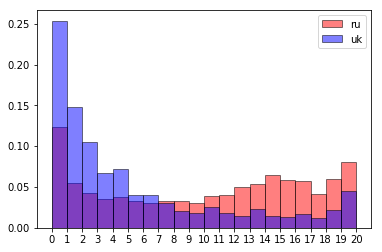

In [107]:
vals_ru = lang_counts_per_acc['ru'].values
vals_uk = lang_counts_per_acc['uk'].values
#np.histogram(vals_ru)
alpha = 0.5
plt.hist(vals_ru, bins=20, color='red', label='ru', alpha=alpha, edgecolor='black', normed=True)
plt.hist(vals_uk, bins=20, color='blue', label='uk', alpha=alpha, edgecolor='black', normed=True)
plt.xticks(range(21))
plt.legend()
plt.show() 

In [160]:
Bcn_lang_per_acc = pd.read_hdf('city_random_walks.h5', 
                               '/Barcelona/tweets_from_followers')

In [161]:
Bcn_lang_per_acc.shape

(115007, 4)

In [162]:
Bcn_lang_per_acc['lang_detected'].value_counts().head()

es           55787
ca           29047
en           15529
Undefined     7166
pt            2228
Name: lang_detected, dtype: int64

In [111]:
lang_counts_per_acc_Bcn = Bcn_lang_per_acc.groupby(['screen_name', 'lang_detected']).count().unstack()['tweets'].fillna(0)[['ca', 'es', 'en', 'Undefined']]
lang_counts_per_acc_Bcn.mean(), lang_counts_per_acc_Bcn.std(), lang_counts_per_acc_Bcn.median()

(lang_detected
 ca           3.782573
 es           7.853094
 en           2.235505
 Undefined    0.984039
 dtype: float64, lang_detected
 ca           4.276879
 es           5.468378
 en           3.851483
 Undefined    1.386437
 dtype: float64, lang_detected
 ca           2.0
 es           7.0
 en           1.0
 Undefined    1.0
 dtype: float64)

In [72]:
np.histogram(vals_es, bins=20)

(array([452, 445, 453, 400, 334, 381, 324, 323, 335, 317, 303, 305, 271,
        307, 290, 259, 201, 182, 133, 125]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]))

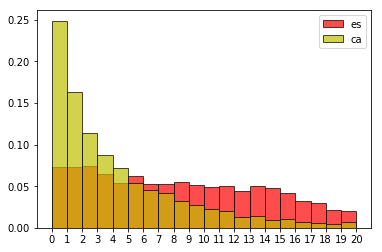

In [114]:
vals_es = lang_counts_per_acc_Bcn['es'].values
vals_ca = lang_counts_per_acc_Bcn['ca'].values
vals_en = lang_counts_per_acc_Bcn['en'].values
np.histogram(vals_es)
plt.hist(vals_es, bins=20, color='r', label='es', alpha=0.7, edgecolor='black', normed=True)
plt.hist(vals_ca, bins=20, color='y', label='ca', alpha=0.7, edgecolor='black', normed=True)
plt.xticks(range(21))
plt.legend()
plt.show()

In [96]:
Kiev_dict = {'KyivOperativ', 'kyivmetroalerts', 'nashkiev', 'auto_kiev', 
             'Leshchenkos', 'poroshenko', 'Vitaliy_Klychko', 'kievtypical', 
             'ukrpravda_news', 'HromadskeUA','lb_ua', 'Korrespondent', 
             'LIGAnet', 'radiosvoboda', '5channel', 'tsnua', 'VWK668', 'Gordonuacom', 'zn_ua',
             'patrolpoliceua'}

In [148]:
Barcelona_dict = {'TMB_Barcelona', 'bcn_ajuntament', 'barcelona_cat', 'LaVanguardia', 'VilaWeb', 
                  'diariARA', 'elperiodico', 'elperiodico_cat', 'elpuntavui', 'meteocat', 'mossos'}

In [31]:
node1 = 'Kiev/KyivOperativ/followers'
node2 = 'Kiev/auto_kiev/followers'

Ky_Op = pd.read_hdf('city_random_walks.h5', node1)
Au_Ki = pd.read_hdf('city_random_walks.h5', node2)

In [34]:
Ky_Op['entities']

In [1109]:
s1 = set(Ky_Op['screen_name'].tolist())
s2 = set(Au_Ki['screen_name'].tolist())
s3 = s1.intersection(s2)
len(s1), len(s2), len(s3)

(674, 1826, 371)

In [1119]:
Ky_Op[Ky_Op['screen_name'].isin(s3)][['followers_count', 'screen_name']].shape

(371, 2)

In [1135]:
(Au_Ki['statuses_count'] / Au_Ki['followers_count'] < 30).value_counts()

True     1274
False     552
dtype: int64

In [1148]:
Au_Ki[['followers_count', 'screen_name', 'statuses_count']][Au_Ki['followers_count'] > 20]

In [166]:
node = 'Barcelona/meteocat/followers'
ww = pd.read_hdf('city_random_walks.h5', node)

In [160]:
#ww.keys()
ww.shape

(2373, 47)

In [66]:
ww[['lang', 'description', 
    'screen_name', 'location']][(ww['followers_count'] > 50) &
                                (ww['location'].str.contains(r"Kiev|Kyiv|Київ|Киев"))].shape

(167, 4)

In [168]:
ww['lang'][(ww['followers_count'] > 40) & 
           (ww['location'].str.contains(r"Barc"))].value_counts()

es       1603
ca        465
en        251
fr          6
en-gb       5
it          5
pt          3
de          2
en-GB       1
gl          1
zh-CN       1
ja          1
Name: lang, dtype: int64

In [1042]:
# ww[['lang', 'description', 'screen_name']][(ww['followers_count'] > 20) & 
#                (ww['location'].str.contains(r"Kiev|Kyiv|Київ|Киев")) &
#                                           (ww['lang'].isin(['ru', 'uk']))]


In [79]:
#ww['description'][ww['description'].str.len() > 10]

In [815]:
txts = [re.sub(r"[^\w\s]+", "", desc, flags=re.U) for desc in descriptions ]
lgs = []
for ix, txt in enumerate(txts):
    try:
        counts = Counter([detect(txt) for _ in range(50)])
        lgs.append([ix, counts])
    except:
        continue

In [833]:
import os
os.mkdir('dummy_dir')

In [834]:
df = pd.DataFrame({'a':np.random.randint(1,10,10), 'b':np.random.randint(1,10,10)})
df.to_hdf('dummy_dir/newHDF5.h5', 'aa/bb/cc')

In [154]:
df_imp = pd.read_hdf('dummy_dir/newHDF5.h5', 'aa/bb/cc')
#df_imp

In [1161]:
oo = pd.read_hdf('city_random_walks.h5', '/Kiev/kyivmetroalerts/followers')

In [1162]:
oo['lang'][oo['location'].str.contains(r"Kiev|Kyiv|Київ|Киев")].value_counts()

ru       155
uk        57
en        41
fr         1
en-gb      1
Name: lang, dtype: int64

In [42]:
rrr = pd.read_hdf('city_random_walks.h5', '/Kiev/tweets_from_followers')

In [46]:
twts.to_hdf?

In [47]:
#[(acc['screen_name'], acc['lang'], acc['location'])  for acc in acc_ntw]

In [756]:
follws = [(acc.statuses_count, acc.lang, acc.screen_name, acc.followers_count, acc.friends_count, acc.location) 
                 for acc in acc_ntw if re.findall(r"Kiev|Kyiv|Киї|Киев", acc.location) and 
                 acc.statuses_count > 50 and acc.lang in ['ru', 'uk']]

In [760]:
bb=list(zip(*follws))
col_keys = ['statuses_count', "lang", 'screen_name', 'followers_count', 'friends_count', 'location']
d_bb = {key:val for key,val in zip(col_keys,bb)}

In [944]:
#pd.DataFrame(d_bb).sort_values(by="statuses_count", ascending=False)

In [ ]:
class RandomWalkCityTweets:
    pass

In [342]:
Kl_follwrs = pd.read_hdf('lang_data.h5', '/ukr/politics/Vitaliy_Klychko/followers')

In [1043]:
# Kl_follwrs[['screen_name', 'followers_count']][(Kl_follwrs['statuses_count'] > 100) & 
#                                                (Kl_follwrs['followers_count'] > 50) &
#                                                (Kl_follwrs['location'].str.contains(r"Kiev|Kyiv|Київ|Киев"))].sort_values(by='followers_count',
#                                                                                                     ascending=False)

In [751]:
ww= get_account_tweets('AnastasijaKaram', max_num_twts=20)

In [70]:
cit_obl = ['Біла Церква', 'Бровари', 'Бориспіль', 'Фастів', 'Ірпінь',
        'Васильків', 'Боярка', 'Вишневе', 'Обухів',
        'Переяслав-Хмельницький', 'Буча', 'Славутич', 'Яготин', 'Вишгород',
        'Сквира', 'Березань', 'Богуслав', 'Тетіїв', 'Українка', 'Кагарлик',
        'Тараща', 'Миронівка', 'Узин', 'Ржищів', 'Чорнобиль', "Прип'ять"]

In [71]:
acc_ntw = get_account_network('huyova_bc', rel_type='followers', max_num =200, key_words=None)

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:06


In [72]:
list_data = [(acc._json['followers_count'], 
  acc._json['statuses_count'], 
  acc._json['screen_name'], 
  acc._json['location'], 
  acc._json['lang']) for acc in acc_ntw]

df = pd.DataFrame(list_data, columns = ['followers_count','statuses_count','screen_name', 'location', 'lang'])

In [1096]:
df_sorted = df.sort_values(by='followers_count', ascending=False)
df_sorted['location'].values

### APPEND DATA TO NODE IN HDF FILE

In [79]:
df_try = pd.DataFrame({'a':range(10,20), 'b': range(30,40)}, 
                      index = random.sample(range(100), 10))
df_try2 = pd.DataFrame({'a':[555,777], 'b': [888, 9999]})

In [80]:
df_try.to_hdf('append_try.h5', '/node_1/b1')

In [82]:
new_df = df_try.append(df_try2, ignore_index=True)

In [83]:
new_df.to_hdf('append_try.h5', '/node_1/b1')

In [256]:
#pd.read_hdf('append_try.h5', '/node_1/b1')

### GET NODES IN HDF FILE

In [64]:
with pd.HDFStore('lang_data.h5') as f:
    list_nodes = f.keys()

In [1044]:
#list_nodes

### IMPROVING LANGUAGE DETECTION

How to filter out URLs and accounts, not relevant for language detection

In [271]:
my_str = "@dijdoer Ukraine is a complex country http://ewdowide.ewd.ewde say @jeiwo @ pgvila http://ewdowide.ewd.ewde I agree"
re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", my_str)

' Ukraine is a complex country  say    I agree'

In [100]:
aa = pd.read_hdf('lang_data.h5', '/ukr_nodes/news/BBC_ua/tls_followers')

In [226]:
follws_BBC = pd.read_hdf('lang_data.h5', '/ukr_nodes/news/BBC_ua/followers')

In [1045]:
#follws_BBC['location'][follws_BBC['location'].str.contains(r"Україна|Ukraine|Украина|Київ|Киев")].value_counts()

In [237]:
relevant_data = follws_BBC[follws_BBC['location'].str.contains(r"Україна|Ukraine|Украина|Київ|Киев")]

In [272]:
clean_txts = [re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", txt)
              for txt in aa['texts'].values[:1000]]

In [273]:
tup_lang_txt = [(txt,detect(txt)) for txt in clean_txts if len(txt) > 20]

In [174]:
ru_txts = [x[0] for x in tup_lang_txt if x[1] == 'ru']

In [175]:
ukr_txts = [x[0] for x in tup_lang_txt if x[1] == 'uk']

In [185]:
len(ru_txts), len(ukr_txts)

(473, 205)

In [176]:
stats_ru =[Counter([detect(x) for _ in range(20)]) for x in ru_txts]

In [177]:
stats_uk =[Counter([detect(x) for _ in range(20)]) for x in ukr_txts]

In [178]:
ru_uncertain = [x for x,y in zip(ru_txts, stats_ru) if y['ru'] < 20]

In [179]:
ukr_uncertain = [x for x,y in zip(ukr_txts, stats_uk) if y['uk'] < 20]

In [182]:
len([(x, y['ru']) for x,y in zip(ru_txts, stats_ru) if y['ru'] < 20])

29

In [183]:
len([(x, y['uk']) for x,y in zip(ukr_txts, stats_uk) if y['uk'] < 20])

19

In [84]:
dummy_data = pd.DataFrame({'a':np.random.randint(1,100,10), 'b':np.random.randint(1,100,10)})

In [96]:
store2 = pd.HDFStore('dummy_ex.h5')

In [99]:
store2.get_node('/node_c/subfolder')

/node_c/subfolder (Group) ''
  children := ['block0_values' (Array), 'axis1' (Array), 'block0_items' (Array), 'axis0' (Array)]

In [86]:
store2['node_a'] = dummy_data['a']

In [87]:
store2['node_b'] = dummy_data['b']

In [88]:
store2.close()

In [97]:
with pd.HDFStore('dummy_ex.h5', ) as g:
    #g.get_node('node_c/subfolder')._f_rename('node_c/subfolder1')
    print(g.keys())
    

['/node_a', '/node_b', '/node_c/subfolder']


In [80]:
df_ = pd.DataFrame({'c':np.random.randint(1,100,10)})

In [90]:
df_.to_hdf('dummy_ex.h5', 'node_c/subfolder')

### Get random tweets from a given coordinate box

In [415]:
# 
data_list, texts, langs, locs = [], [], [], []

class StdOutListener(StreamListener):
    """ A listener handles tweets are the received from the stream.
    This is a basic listener that just prints received tweets to stdout.
    """
    
    def __init__(self):
        self.data_list = []
        self.texts = []
        self.langs = []
    
    def on_data(self, data):
        jd = json.loads(data)
        self.data_list.append(jd)
        self.texts.append(jd['text'])
        self.langs.append(jd['lang'])
        try:
            print(data)
            saveFile = open('newtweets.csv', 'a')
            saveFile.write(data).encode("utf8")
            saveFile.write('/n').encode("utf8")
            saveFile.close()
            return True
        except BaseException:
            print ('failed ondata')
            time.sleep(5)

    def on_error(self, status):
        print(status)

In [416]:
#coordinates
Lviv = [23.882904,49.763526,24.163055,49.921167]
Kiev = [30.449982,50.408518,30.639496,50.495958]
Yerevan = [44.329834,40.078071,44.681396,40.296287]
Brussel = [4.258575,50.788575,4.489288,50.913424]
Barcelona = [1.835403,41.375778,2.241898,41.586688]

In [10]:
# #Barcelona
# l_Barc = StdOutListener()
# #ASK FOR KEYWORD TO COLLECT DATA
# stream_Barc = Stream(auth, l_Barc)
# stream_Barc.filter(locations=Barcelona)

In [9]:
#Counter(l_Barc.langs)
# for data, lang in zip(l_Barc.data_list, l_Barc.langs):
#     print(data['user']['location'], lang)
for text in l_Barc.texts:
    if type(text) == str:
        print(text)
    else:
        print(text.decode('utf-8'))

In [10]:
# for ee in l_Barc.data_list:
#     print(ee['place']['id'], ee['place']['place_type'])

In [11]:
# #Brussel
# l_Bru = StdOutListener()
# #ASK FOR KEYWORD TO COLLECT DATA
# stream_Bru = Stream(auth, l_Bru)
# stream_Bru.filter(locations=Brussel)

In [12]:
# #Counter(l_Bru.langs)
# for data, lang in zip(l_Bru.data_list, l_Bru.langs):
#     print(data['user']['location'], lang)

In [13]:
# #LVIV
# l_Lv = StdOutListener()
# #ASK FOR KEYWORD TO COLLECT DATA
# stream_Lv = Stream(auth, l_Lv)
# stream_Lv.filter(locations=Lviv)

In [14]:
# #YEREVAN
# l_Yer = StdOutListener()
# #ASK FOR KEYWORD TO COLLECT DATA
# stream_Yer = Stream(auth, l_Yer)
# stream_Yer.filter(locations=Yerevan)

In [15]:
# for data, lang in zip(l_Yer.data_list, l_Yer.langs):
#     print(data['user']['location'], lang)

In [16]:
# for text in l_Yer.texts:
#     if type(text) == str:
#         print(text)
#     else:
#         print(text.decode('utf-8'))

In [17]:
# for data, lang in zip(data_list, langs):
#     print(data['user']['location'], lang)

In [18]:
#KIEV
l_Kiev = StdOutListener()
#ASK FOR KEYWORD TO COLLECT DATA
stream_Kiev = Stream(auth, l_Kiev)
stream_Kiev.filter(locations=Kiev)

In [19]:
#Counter(l_Kiev.langs)
# for data, lang in zip(l_Kiev.data_list, l_Kiev.langs):
#     print(data['user']['location'], lang)
for text in l_Kiev.texts:
    if type(text) == str:
        print(text)
    else:
        print(text.decode('utf-8'))

In [20]:
for data in l_Kiev.data_list:
    print(data['place']['id'], data['place']['place_type'], 
          data['place']['country'], data['user']['location'])

In [125]:
for text in texts:
    if type(text) == str:
        print(text)
    else:
        print(text.decode('utf-8'))


### DYNAMO KIEV PLAYERS

In [253]:
# DYNAMO PLAYERS

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

url = "http://www.worldfootball.net/teams/dinamo-kiev/2017/2/"
html = requests.get(url)
soup = BeautifulSoup(html.text, "lxml")

# dynamo_players = pd.read_html(url, encoding='utf8')[1][2].dropna().value
dynamo_players

In [56]:
dyn_play_countr = pd.read_html(url, encoding='utf8')[1][[2,4]].dropna().values

dyn_play_countr

### PYMONGO

In [5]:
from pymongo import MongoClient

conn=MongoClient()

#define database
db = conn.citylangs

#define collection inside database
collection = db.bcn.ajuntam.followers

# function to add documents to collection 
def make_followers_collection(account_name, collection, max_num=100):
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    users = tweepy.Cursor(api.followers, screen_name=account_name).items(max_num)
    #i = 0
    while True:
        try:
            user = next(users)
            collection.insert_one(user._json)
        except tweepy.TweepError as e:
            if 'Read timed out' in str(e):
                print('fall here')
                print(e)
                time.sleep(5)
            else:
                time.sleep(60*16)
                user = next(users)
        except StopIteration:
            break
        #print ("@" + user.screen_name)
    #return collection

make_followers_collection('bcn_ajuntament',collection, max_num=100)

#check what databases are available
conn.database_names()

# available collections inside db
db.collection_names()

collection2 = db.kiev.ukrpravda

make_followers_collection('ukrpravda_news',collection2, max_num=300)

l = list(conn.citylangs.kiev.ukrpravda.find())

Counter([obj['lang'] for obj in l])


db.collection_names()

#db.categories.insert_one({ "_id": "ukr_pravda", "children": [] })
# db.categories.insert({ _id: "avto_kiev", children: [] })
# db.categories.insert({ _id: "kiev", children: ["ukr_pravda", "avto_kiev"] })

db['kiev'].insert_one({'avto_kiev':[],'vitklitschko':[]})

db.collection_names()

rr=list(db['bcn.ajuntam.followers'].find())

db['kiev'].find_one()

db['bcn.ajuntam.followers']

conn.database_names()

coll2 = db.countries

### HOW TO LOAD AND SAVE DATA FROM/TO HDF USING PANDAS : STORE, READ_HDF, TO_HDF

In [402]:
store3 = pd.HDFStore('dummy_example.h5')

In [405]:
store3['a'] = pd.DataFrame([1,2,3])
store3['b'] = pd.DataFrame([4,5,6])

In [406]:
store3.close()

In [407]:
pd.read_hdf('dummy_example.h5', 'a')

,0
0,1
1,2
2,3


In [432]:
store = pd.HDFStore('dummy_example.h5')

In [433]:
store.keys()

['/b', '/c', '/dd/ee', '/dd/ee/123']

In [435]:
store['/dd/ee/123']

,0
0,15
1,11
2,10
3,15
4,14


In [436]:
store.close()

In [431]:
x=pd.DataFrame(np.random.randint(10,20,5))
x.to_hdf('dummy_example.h5', 'dd/ee/123')

//anaconda/lib/python3.5/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [651]:
string1 = "ewfw[uim]wqw[erty]weabbatraaaa[wdqwdaddacsdvsdc]qwdeoddowrfre"
string2 = "dedwwww[qdew]cewc"
string3 = "[dew]ciao[rferf]sonopaolo[rferfe]come[dwe]va"

In [652]:
re.findall(r"\[(\w+)\]", string1)

['uim', 'erty', 'wdqwdaddacsdvsdc']

In [653]:
xx=re.findall(r"[^(\[\w+\])]", string1)

In [663]:
def get_out_brack():
    return re.split(r"\[|\]", string3)[::2]

    

In [664]:
get_out_brack()

['', 'ciao', 'sonopaolo', 'come', 'va']

In [642]:
re.findall(r"\w+",' '.join([y for x in re.findall(r"(\w*)\[\w+\](\w*)", string3) for y in x]))

['ciao', 'sonopaolo', 'come', 'va']

In [529]:
[y for x in xx for y in x]

['ewfw', 'wqw', 'weabbatraaaa', 'qwdeoddow']

In [ ]:
r"*\w*(\w)(\w)\3\2\w*\[(\w+)\]\w*(\w)(\w)\5\4\w*"

In [498]:
grs

[]

In [501]:
re.split(r"\[|\]", string2)

['dedwwww', 'qdew', 'cewc']

In [485]:
[re.findall(r"(\w)(\w)\2\1", x) for x in grs if len(x) == 4][0][0]

IndexError: list index out of range

### learning tweepy

In [1055]:
# import tweepy

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# api = tweepy.API(auth)

# public_tweets = api.home_timeline()


In [1053]:
txts = [re.sub(r"(@\s?[^\s]+|https?://?[^\s]+)", "", twt.text)  for twt in public_tweets]

Counter([detect(txt) for txt in txts if re.sub(" ","", txt)])

In [1136]:
dummy_user = api.get_user('budgetvoyage')

In [1067]:
dummy_user_friends = [friend for friend in dummy_user.friends(100)]

In [1138]:
dummy_user_followers = dummy_user.followers(count=100)

In [1145]:
[(acc.screen_name, acc.location) for acc in dummy_user_followers if re.findall(r"Киев|Kiev|Kyiv|Київ", acc.location) ]

[('OLytovka', 'Киев'), ('ViaSotnyk', 'Украина, Киев')]

In [1080]:
dummy_user_followers[0].description

'Оборудование для супермаркетов, магазинов шаговой доступности и ресторанов'

In [1086]:
my_flws = api.followers(count=40)

In [252]:
#[flw.screen_name for flw in my_flws]

In [9]:
import requests
from bs4 import BeautifulSoup

In [10]:
web_page = requests.get("http://zik.ua/news/2015/05/18/vynnychuk_kyiv_v_okupatsii_rosiyskogo_ukrainska_mova_u_stolytsi__na_zadvirkah_590723")

In [13]:
soup = BeautifulSoup(web_page.text, "lxml")

In [31]:
mystr = "& % #ewoihdoew wefjerpfjr l'Arnau va dir: de cap manera ! ? . Ves-hi tu"
re.findall(r"[^\w\s'?]+", mystr)

['&', '%', '#', ':', '!', '.', '-']

In [152]:
"rpeofjer. ferfkepr// fkpe".replace(r" ", "").replace(r"[^\w\s'’,.!?]+", "")

'rpeofjer.ferfkepr//fkpe'

In [154]:
import re

In [159]:
re.sub(r"[^\w\s'’,.!?]+", "", "#rpeofjer. ferfke:pr// fkpe?")

'rpeofjer. ferfkepr fkpe?'